# Pre-Processing & Modeling

### Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Processing and Models
import regex as re
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Pre-processing

In [2]:
# read in csv files
posts = pd.read_csv('../data/posts_clean.csv')
posts.head()

,subreddit,text
0,0,"Hey all,\n\nI'm posting this. . . Well, bc the..."
1,0,I’m trying to find a responsible way to get ri...
2,0,This documentary is breaking my heart.Planet o...
3,0,Destroying a natural simbiotic system (nature)...
4,0,2 million chickens will be killed in Delaware ...


In [3]:
# check duplicates
posts.duplicated().sum()

195

In [4]:
# Drop second duplicated column
posts.drop_duplicates(keep='first', inplace=True)

In [5]:
# Check shape
posts.shape

(7376, 2)

In [6]:
# Clean the text column by removing html code 
# and making all letters lowercase
posts["text"] = posts["text"].str.replace('[^a-zA-Z ]', ' ')
posts["text"] = posts["text"].str.replace(r'http\S+', '')
posts["text"] = posts["text"].str.replace(r'\[http\S+', '')
posts["text"] = [post.lower().strip() for post in posts['text']]

In [7]:
# Separate dataframes for each subreddit
env_posts = posts[posts['subreddit']==0]
tech_posts = posts[posts['subreddit']==1]

# Get character count for each subreddit
env_char = sum([len(post) for post in env_posts['text']])
tech_char = sum([len(post) for post in tech_posts['text']])

# Get average post length
env_avg = env_char / len(env_posts)
tech_avg = tech_char / len(tech_posts)
                           
print(f"r/environment has {env_char - tech_char} more characters than r/technology.")
print(f"Average character count for r/environment posts: {env_avg}")
print(f"Average character count for r/technology posts: {tech_avg}")

r/environment has 2056871 more characters than r/technology.
Average character count for r/environment posts: 831.7511111111111
Average character count for r/technology posts: 248.26085805084745


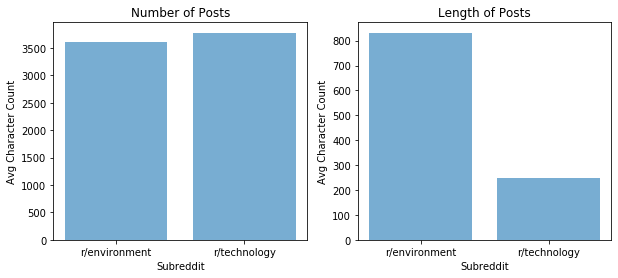

In [8]:
plt.figure(figsize=(10,4)) 

objects = ('r/environment', 'r/technology')
y_pos = np.arange(len(objects))
height1 = [len(env_posts), len(tech_posts)]
height2 = [env_avg, tech_avg]

# Visualize difference in number of posts
plt.subplot(1,2,1)
plt.bar(y_pos, height1, align='center', alpha=0.6,)
plt.xticks(y_pos, objects)
plt.xlabel('Subreddit')
plt.ylabel('Avg Character Count')
plt.title('Number of Posts')

# Visualize difference in avg post length
plt.subplot(1,2,2)
plt.bar(y_pos, height2, align='center', alpha=0.6,)
plt.xticks(y_pos, objects)
plt.ylabel('Avg Character Count')
plt.xlabel('Subreddit')
plt.title('Length of Posts');

### Train, test, split

In [9]:
# prepare the data for modeling
X = posts['text']
y = posts['subreddit']

In [10]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [12]:
# What does the training dataset look like
print(f'There are a total of {X_train.shape[0]} posts in the training set.')

There are a total of 5532 posts in the training set.


## CountVectorize

In [13]:
# Add my own stopwords to SKlearn's set of stopwords
stops_sk = ENGLISH_STOP_WORDS.union({'http', 'https', 'www', 'com', 'org', 'amp'})

# Add my own stopwords to nltk's set of stopwords
stops_nltk = stopwords.words('english') + ['http', 'https', 'www', 'com', 'org', 'amp']

In [14]:
# Use CountVectorize to explore common words
cvec = CountVectorizer(stop_words=stops_sk, ngram_range=(1, 1))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

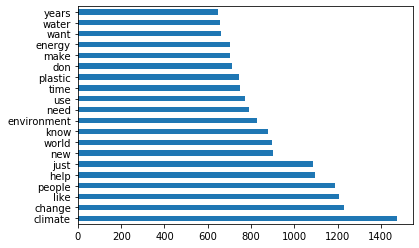

In [15]:
# Put vectorized words into a df to explore - todense() will return a dense matrix
words = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names())

# check which words are appearing the most
words.sum().sort_values(ascending=False).head(20).plot(kind='barh');

### Tokenize, Stem, Lemmatize

In [16]:
# Instantiate tokenizer and stemmer
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

# Stem X_train and save words to empty list
stemmed_words=[]

for word in X_train:
    tokens = tokenizer.tokenize(word)
    row = [p_stemmer.stem(token) for token in tokens]
    stemmed_words.append(row)

In [17]:
# Join the stemmed words together and save as X_train
X_train = [' '.join(row) for row in stemmed_words]
X_train[:1]

['with so much shortag of water around the world special with what ha happen in chennai what are a few product to use to save water on a daili basi save water']

In [18]:
# Stem X_test and save words to empty list
stemmed_words=[]

for word in X_test:
    tokens = tokenizer.tokenize(word)
    row = [p_stemmer.stem(token) for token in tokens]
    stemmed_words.append(row)

In [20]:
# Join the stemmed words together and save as X_test
X_test = [' '.join(row) for row in stemmed_words]
X_test[:1]

['green parti in the world']

# Modeling

In [21]:
# Get baseline accuracy
y_test.value_counts(normalize=True)

1    0.511931
0    0.488069
Name: subreddit, dtype: float64

The dataset is slightly unbalanced. The baseline accuracy will be based off the majority class (1), so it is 52.26%. If we see accuracy scores lower than the baseline accuracy it would indicate the models are performing worse than randomly guessing 52.26% of the posts are coming from the technology subreddit.  

## Logistic Regression
I start with a logistic regression model because it is easy to interpret and can indicate which variables are considered important by the model. Count vectorizer provides a numeric representation of how often certain words appear in a document.

In [24]:
pipe_cvec_lr = Pipeline([('cvec', CountVectorizer()),
                         ('lr', LogisticRegression(random_state=42, max_iter=400))])

In [25]:
params_cvec_lr = {
    'cvec__stop_words':[stops_sk, stops_nltk],
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.85, .9],
    'cvec__ngram_range': [(1,1), (1,2)], 
    'lr__C': [0.01, 0.1, 1, 10]
}

# Instantiate GridSearchCV
gs_cvec_lr = GridSearchCV(pipe_cvec_lr,
                  param_grid=params_cvec_lr, 
                  cv=3) 

# Fit GridSearch to training data.
gs_cvec_lr.fit(X_train, y_train)

# Score model and check best params/model
print(f'Best Score: {gs_cvec_lr.best_score_}')
print(f'Train Score: {gs_cvec_lr.score(X_train, y_train)}')
print(f'Test Score: {gs_cvec_lr.score(X_test, y_test)}')
print(f'Best Params: {gs_cvec_lr.best_params_}')

Best Score: 0.930947216196674
Train Score: 0.9844540853217643
Test Score: 0.9392624728850325
Best Params: {'cvec__max_df': 0.85, 'cvec__max_features': 3500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': frozenset({'bill', 'back', 'move', 'was', 'afterwards', 'again', 'somehow', 'since', 'already', 'latter', 'least', 'ie', 'been', 'enough', 'so', 'yourself', 'nothing', 'his', 'into', 'being', 'whereafter', 'everywhere', 'throughout', 'eg', 'to', 'together', 'over', 'made', 'both', 'call', 'above', 'until', 'first', 'everyone', 'amp', 'a', 'even', 'name', 'thick', 'no', 'describe', 'whereby', 'same', 'whole', 'me', 'namely', 'he', 'top', 'you', 'please', 'if', 'are', 'all', 'every', 'six', 'de', 'less', 'now', 'therein', 'ten', 'i', 'them', 'wherever', 'which', 'against', 'ours', 'found', 'during', 'be', 'has', 'ourselves', 'eleven', 'last', 'each', 'on', 'noone', 'everything', 'yourselves', 'as', 'anywhere', 'two', 'were', 'rather', 'still', 'what', 'whatever', 'th

In [26]:
# Generate predictions
gs_cvec_lr_preds = gs_cvec_lr.predict(X_test)

In [27]:
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, gs_cvec_lr_preds).ravel()

# Calculate sensitivity and specificity
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec,4)}')
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9067
Sensitivity: 0.9703


### Interpretation
- The model has a strong performance, with the train set scoring higher than the test set - model is overfitting to the data.
- hyperparameters: considering trying lower values for max_df

## Logistic Regression 2
TFIDFVectorizer returns a word's value proportionally to count. It is offset by the frequency of the word in the corpus.

In [28]:
pipe_tfidf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                         ('lr', LogisticRegression(random_state=42, max_iter=400))])

In [29]:
# Search over the following values of hyperparameters:
params_tfidf_lr = {
    'tfidf__stop_words':[stops_sk, stops_nltk],
    'tfidf__max_features': [3000, 3500],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,2)],
    'lr__C': [10, 15, 20]
}

# Instantiate GridSearchCV
gs_tfidf_lr = GridSearchCV(pipe_tfidf_lr,
                  param_grid=params_tfidf_lr, 
                  cv=3) 

# Fit GridSearch to training data.
gs_tfidf_lr.fit(X_train, y_train)

# Score model and check best params/model
print(f'Best Score: {gs_tfidf_lr.best_score_}')
print(f'Train Score: {gs_tfidf_lr.score(X_train, y_train)}')
print(f'Test Score: {gs_tfidf_lr.score(X_test, y_test)}')
print(f'Best Params: {gs_tfidf_lr.best_params_}')

Best Score: 0.9363702096890817
Train Score: 0.9924078091106291
Test Score: 0.9376355748373102
Best Params: {'lr__C': 10, 'tfidf__max_df': 0.9, 'tfidf__max_features': 3500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': frozenset({'bill', 'back', 'move', 'was', 'afterwards', 'again', 'somehow', 'since', 'already', 'latter', 'least', 'ie', 'been', 'enough', 'so', 'yourself', 'nothing', 'his', 'into', 'being', 'whereafter', 'everywhere', 'throughout', 'eg', 'to', 'together', 'over', 'made', 'both', 'call', 'above', 'until', 'first', 'everyone', 'amp', 'a', 'even', 'name', 'thick', 'no', 'describe', 'whereby', 'same', 'whole', 'me', 'namely', 'he', 'top', 'you', 'please', 'if', 'are', 'all', 'every', 'six', 'de', 'less', 'now', 'therein', 'ten', 'i', 'them', 'wherever', 'which', 'against', 'ours', 'found', 'during', 'be', 'has', 'ourselves', 'eleven', 'last', 'each', 'on', 'noone', 'everything', 'yourselves', 'as', 'anywhere', 'two', 'were', 'rather', 'still', 'what

In [30]:
# Generate predictions
gs_tfidf_lr_preds = gs_tfidf_lr.predict(X_test)

In [31]:
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, gs_tfidf_lr_preds).ravel()

# Calculate sensitivity and specificity
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec,4)}')
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9144
Sensitivity: 0.9597


### Interpretation
- The model outperformed the baseline and had a slightly higher accuracy on the test set than the logistic regression model using Countvectorizer. However it is more overfit.
- The models are classifying very well, but this is not great for my problem statement! There is a clear distinction between the technology and environment subreddits.

## Multinomial Naive Bayes
A Multinomial Naive Bayes model is used because count vectorizer gives us an integer count of words in a document. It's a very fast modeling algorithm and an excellent classifier, outperforming more complicated models.

In [32]:
# Instantiate Naive Bayes model
mnb = MultinomialNB()
cvec = CountVectorizer()

# Countvectorize on x_train and x_test data
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

# Fit MNB to training data
mnb.fit(X_train_cvec, y_train)

# Make predictions
y_pred_train = mnb.predict(X_train_cvec)
y_pred_test = mnb.predict(X_test_cvec)

# Score model and check best params/model
print(f'Train Score: {mnb.score(X_train_cvec, y_train)}')
print(f'Test Score: {mnb.score(X_test_cvec, y_test)}') 

Train Score: 0.9596890817064353
Test Score: 0.9311279826464208


In [33]:
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

# Calculate sensitivity and specificity
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec,4)}')
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9678
Sensitivity: 0.8962


### Interpretation
- It was worth testing this model, but important to recognize it's shortcomings. Naive Bayes models assume that all of our features are independent of one another, which isn't necessarily true with language data. Certain words are more likely to follow other words, and certain words are less likely to follow other words.

## Random Forest
Random Forests are relatively simple to use because they require very few parameters to set and they perform pretty well. 

In [34]:
pipe_tfidf_rf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('rf', RandomForestClassifier(random_state=42))])

In [35]:
params_tfidf_rf ={
    'tfidf__stop_words':[stops_nltk],
    'tfidf__max_features': [2500, 3000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators':[50,100],
    'rf__max_depth':[None,1,2,3,4],
    'rf__min_samples_split':[2,4,6]
}

# Instantiate Gridsearch
gs_tfidf_rf = GridSearchCV(pipe_tfidf_rf, 
                     param_grid=params_tfidf_rf, 
                     cv=3)

# Fit Gridsearch to the training data
gs_tfidf_rf.fit(X_train, y_train)

# Score model and check best params/model
print(f'Best Params: {gs_tfidf_rf.best_params_}')
print(f'Best Score: {gs_tfidf_rf.best_score_}')
print(f'Train Score: {gs_tfidf_rf.score(X_train, y_train)}')
print(f'Test Score: {gs_tfidf_rf.score(X_test, y_test)}') 

Best Params: {'rf__max_depth': None, 'rf__min_samples_split': 4, 'rf__n_estimators': 100, 'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',

In [36]:
# Generate predictions
gs_tfidf_rf_preds = gs_tfidf_rf.predict(X_test)

In [37]:
# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, gs_tfidf_rf_preds).ravel()

# Calculate sensitivity and specificity
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec,4)}')
print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9156
Sensitivity: 0.9269


### Interpretation
- The Random Forest Model is overfit, indicated by the significantly higher training score. This can also be concluded because the best max_depth parameter is 'None', which indicates an overfit tree.
- As we increased variation by adding the min samples split parameter, we saw a slight decrease in the model's performance. The min_samples_split parameter could be driving max_depth to none. 
- Parameters indicate a lower number of trees is ideal.

| model | transformer | estimator | train accuracy | test accuracy | sensitivity | specificity |
|-------|--------------|-------------|-----------------|----------|------------|------------------|
| 1 | CountVectorizer | Logistic Regression | 98.4% | 93.9% | 97.0% | 90.7% |
| 2 | TfidfVectorizer | Logistic Regression | 99.2% | 93.8% | 96.0% | 91.4% |
| 3 | CountVectorizer | Multinomial Naive Bayes | 96.0% | 93.8% | 89.6% | 96.8% |
| 4 | TfidfVectorizer | Random Forest Classifier | 99.8% | 92.1% | 91.2% | 93.1% |

# References

Preprocessing and EDA  
https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python  
https://pythonspot.com/matplotlib-bar-chart/  